<a href="https://colab.research.google.com/github/yoonhero/resemble_gan/blob/master/ResembleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jan 29 11:15:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive'

Mounted at /content/drive


In [3]:
!pip install ninja
!pip install timm
!pip install gdown --upgrade
!git clone https://github.com/NVlabs/stylegan3.git

import torch
import torch.optim as optim
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def make_transform(translate, angle):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.16 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [4]:
%cd stylegan3

import legacy

!wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl" -O "afhqv2-model.pkl"

  
with open("afhqv2-model.pkl", "rb")as file:
    G = legacy.load_network_pkl(file)["G_ema"].to(device)

# Construct an inverse rotation/translation matrix and pass to the generator.  The
# generator expects this matrix as an inverse to avoid potentially failing numerical
# operations in the network.
if hasattr(G.synthesis, "input"):
    m = make_transform((0, 0), 0)
    m = np.linalg.inv(m)
    G.synthesis.input.transform.copy_(torch.from_numpy(m))


/content/stylegan3
--2023-01-29 11:16:13--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.53.73.145, 54.219.61.22
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.53.73.145|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-r-afhqv2-512x512.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJIMEYCIQD5TUfyqt9WNY4ev2LX8fJE5UNca6siuzaHI897yRtGWAIhANUpiM664XOhn9MEg11JoDgEZzHjMfpdC6Cwo9Ryk%2FbbKrEFCHQQBBoMNzg5MzYzMTM1MDI3Igy%2BfxihUAYQ9U6%2BuIwqjgX6es8B5f%2FkkQ0YQJsibS%2FADuc%2FOvsiCw9WLsQgV4vfy9Lox9XNLpO5%2Ba5t5hox5hg19pciJN1jdVY

In [122]:
def generate_image(latent_vectors, label):
    image = G(latent_vectors, label, truncation_psi=1, noise_mode="const")
    image = (image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

    return image

In [123]:
print(f"Latent Vector dimentsion : {G.z_dim}")

Latent Vector dimentsion : 512


In [124]:
label = torch.zeros([1, G.c_dim], device=device)
latents = torch.randn(1, G.z_dim).to(device)
generated = generate_image(latents, label)

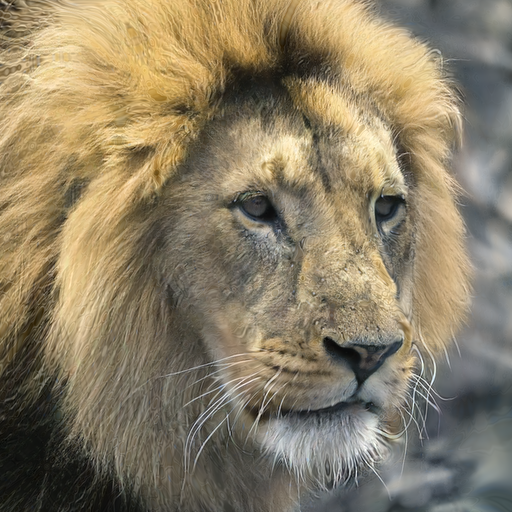

In [125]:
output_image = Image.fromarray(generated[0].cpu().numpy(), "RGB")

output_image

In [9]:
print(f"Generated Image Shape : {generated.shape}")

Generated Image Shape : torch.Size([1, 512, 512, 3])


In [80]:
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=T.ToTensor()):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        target_x = self.x[idx]
        target_y = self.y[idx]

        img_x = Image.open(target_x).convert('RGB')
        img_y = Image.open(target_y).convert('RGB')


        transformed_img_x = self.transform(img_x)
        transformed_img_y = self.transform(img_y)

        #print(idx, transformed_img_x.shape, transformed_img_y.shape)

        return transformed_img_x, transformed_img_y

In [81]:
import glob

x = glob.glob(os.path.join("""/content/drive/My Drive""", "dataset/after/human/*"))
y = glob.glob(os.path.join("""/content/drive/My Drive""", "dataset/after/animal/*"))


def sort_key(path):
    return int(path.split("\\")[-1].split("_")[-1].split(".")[0])

x = sorted(x, key=lambda x: sort_key(x))
y = sorted(y, key=lambda y: sort_key(y))

x[:5], y[:5], len(x)

(['/content/drive/My Drive/dataset/after/human/train_0.jpg',
  '/content/drive/My Drive/dataset/after/human/train_1.jpg',
  '/content/drive/My Drive/dataset/after/human/train_2.jpg',
  '/content/drive/My Drive/dataset/after/human/train_3.jpg',
  '/content/drive/My Drive/dataset/after/human/train_4.jpg'],
 ['/content/drive/My Drive/dataset/after/animal/train_0.jpg',
  '/content/drive/My Drive/dataset/after/animal/train_1.jpg',
  '/content/drive/My Drive/dataset/after/animal/train_2.jpg',
  '/content/drive/My Drive/dataset/after/animal/train_3.jpg',
  '/content/drive/My Drive/dataset/after/animal/train_4.jpg'],
 126)

In [82]:
from torch.utils.data import random_split

transform = T.Compose([
    T.ToTensor(),
    T.Resize((512, 512))
])

dataset = CustomDataset(x, y, transform)
dataset_size = len(dataset)
train_size = dataset_size
#train_size = int(dataset_size*0.8)
#validation_size = dataset_size - train_size

#train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_dataset = dataset

print(f"Training Data Size: {train_size}")
#print(f"Validation Data Size: {validation_size}")

Training Data Size: 126


In [83]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

train_size = len(train_dataloader)

In [84]:
lr_init = 0.025
nb_epochs = 1500
weight_decay = 0.01

show_interval = 10

In [156]:
def save_result(input_images, output_images):
    #original_grid = torchvision.utils.make_grid(input_images, nrow=4).permute(1, 2, 0)
    #predicted_grid = torchvision.utils.make_grid(output_images, nrow=4).permute(1, 2, 0)

    folder_name = str(datetime.now())

    output_dir = os.path.join(f"{drive_path}/output",folder_name)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    torchvision.utils.save_image(input_images.cpu().detach(), os.path.join(output_dir, "input_image.png"), nrow=4)
    #torchvision.utils.save_image(output_images.cpu().detach(), os.path.join(output_dir, "predicted_animal_face.png"), nrow=4)
    
    output_images = output_images.cpu().detach()
    
    for idx, output_image in enumerate(output_images):
        im = Image.fromarray(y_pred[0].cpu().numpy(), "RGB")
        output_file_dir = os.path.join(output_dir, f"predicted_animal_face_{idx}.png")
        im.save(output_file_dir)

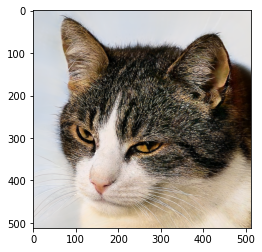

In [159]:
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)

    latent_vector = model(y)
    label = torch.zeros([1, G.c_dim], device=device)

    #print(latent_vector)

    y_pred = generate_image(latent_vector, label)
    output_image = Image.fromarray(y_pred[0].cpu().numpy(), "RGB")
    plt.imshow(output_image)
    plt.show()

    save_result(y, y_pred.float())

    break

In [144]:
latents = torch.randn(16, G.z_dim).to(device)
label = torch.zeros([1, G.c_dim], device=device)
y_pred = generate_image(latents, label)

#y_pred = y_pred.reshape(y_pred.shape[0], 3, 512, 512)
y_pred = y_pred.cpu().detach()

def image_grid(imgs, rows, cols):
    w, h = Image.fromarray(imgs[0]).convert('RGB').size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        image = Image.fromarray(img).convert('RGB')
        plt.imshow(image)
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# print(y_pred.shape, type(y_pred))
# grid = image_grid(y_pred, 4, 4)

torch.Size([3, 512, 512])


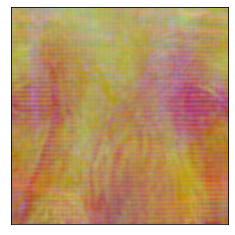

In [155]:
import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list): # 하나의 이미지일때
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 총 사진의 개수만큼 plot
    for i, img in enumerate(imgs):
        print(img.shape)
        img = img.detach() # 학습 그래프에서 제외
        img = F.to_pil_image(img) # torch.tensor 에서 pil 이미지로 변환
        axs[0, i].imshow(np.asarray(img)) # numpy 배열로 변경후, 가로로 이미지를 나열
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
y_pred = y_pred.reshape(y_pred.shape[0], 3, 512, 512)
show(y_pred[0])

In [95]:
import torch
import torch.nn as nn
from torchvision import models

class ResembleGAN(nn.Module):
    def __init__(self, latent_size):
        super(ResembleGAN, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        self.fc1 = nn.Linear(1000, 2000)
        self.fc2 = nn.Linear(2000, 2000)
        self.fc3 = nn.Linear(2000, latent_size)
        
        self.relu = nn.ReLU()

        self.net = nn.Sequential(
            self.fc1, 
            self.relu,
            self.fc2, 
            self.relu,
            self.fc3
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], 3, 512, 512)

        latent_vector = self.resnet(x)

        out = self.net(latent_vector)

        return out

In [96]:
def l2_loss_function(y, y_hat):
    criterion = nn.MSELoss()
    loss = criterion(y, y_hat)

    return loss 

In [97]:
import torch.optim as optim

latent_size = G.z_dim

model = ResembleGAN(latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr_init, weight_decay=weight_decay)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [98]:
for parameter in G.parameters():
    parameter.requires_grad = False

## 1. MSELoss for Training...

Maybe it doesn't work well.

In [160]:
import torchvision
from datetime import datetime 
import os 
criterion = nn.MSELoss()

for epoch in range(nb_epochs):
    losses = 0

    for batch_idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        latent_vector = model(y)
        label = torch.zeros([1, G.c_dim], device=device)

        y_pred = generate_image(latent_vector, label)

        y_pred_ = y_pred.reshape(y_pred.shape[0], 3, 512, 512)
        
        loss = criterion(y, y_pred_)
        losses += loss.item()
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()

    losses /= train_size
   
    print(f"Epoch: {epoch}/{nb_epochs} | Training Loss: {losses}")      

    if (epoch+1) % show_interval == 0:
        #y_pred = y_pred.reshape(y_pred.shape[0], 512, 512, 3)
        save_result(y, y_pred)

Epoch: 0/1500 | Training Loss: 21567.10909598214
Epoch: 1/1500 | Training Loss: 21186.065011160714
Epoch: 2/1500 | Training Loss: 21646.610491071428
Epoch: 3/1500 | Training Loss: 21148.028459821428
Epoch: 4/1500 | Training Loss: 21318.967633928572
Epoch: 5/1500 | Training Loss: 20970.783203125
Epoch: 6/1500 | Training Loss: 20815.126395089286
Epoch: 7/1500 | Training Loss: 21349.556082589286
Epoch: 8/1500 | Training Loss: 20945.635602678572
Epoch: 9/1500 | Training Loss: 21298.658203125
Epoch: 10/1500 | Training Loss: 21417.007254464286
Epoch: 11/1500 | Training Loss: 21492.828962053572
Epoch: 12/1500 | Training Loss: 21028.241629464286
Epoch: 13/1500 | Training Loss: 21146.270647321428
Epoch: 14/1500 | Training Loss: 21121.08203125
Epoch: 15/1500 | Training Loss: 20859.455636160714
Epoch: 16/1500 | Training Loss: 21173.245535714286
Epoch: 17/1500 | Training Loss: 20743.785993303572
Epoch: 18/1500 | Training Loss: 20837.133370535714
Epoch: 19/1500 | Training Loss: 21193.15262276786
Ep

KeyboardInterrupt: ignored

## 2. BCELoss & Upgraded Encoder

In [161]:
!pip install lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.0/330.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 52.1 MB/s eta 0:00:00


In [170]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, latent_size):
    super(ConvAutoEncoder, self).__init__()
    
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 5, kernel_size = 5),
      nn.ReLU(),
      nn.Conv2d(5, 7, kernel_size = 5),
      nn.ReLU()
    )

    self.fc_layer = nn.Sequential(
        nn.Linear(1778112, latent_size)
    )
    
  def forward(self, x):
    out = self.encoder(x)

    out = out.view(out.size(0), -1)

    out = self.fc_layer(out)

    return out

model_ = ConvAutoEncoder(latent_size)
x = torch.randn((1,3,512, 512))

model_(x).shape

torch.Size([1, 512])

In [176]:
import torch.optim as optim

latent_size = G.z_dim

model = ConvAutoEncoder(latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr_init, weight_decay=weight_decay)

criterion = nn.MSELoss(reduction='none')

for epoch in range(nb_epochs):
    losses = 0

    for batch_idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        latent_vector = model(y)
        print(latent_vector.shape)
        label = torch.zeros([1, G.c_dim], device=device)

        y_pred = generate_image(latent_vector, label)

        y_pred_ = y_pred.reshape(y_pred.shape[0], 3, 512, 512)
        
        loss = criterion(y, y_pred_)
        losses += loss.item()
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()

    losses /= train_size
   
    print(f"Epoch: {epoch}/{nb_epochs} | Training Loss: {losses}")      

    if (epoch+1) % show_interval == 0:
        #y_pred = y_pred.reshape(y_pred.shape[0], 512, 512, 3)
        save_result(y, y_pred)

torch.Size([16, 512])


ValueError: ignored